# GANs = Generative adversarial network

## Question: Generating Fashion Products with GAN
- Dataset Problem: Use the Fashion MNIST dataset to train a GAN for generating new fashion product images. 
The Fashion-MNIST dataset is proposed as a more challenging replacement dataset for the
MNIST dataset. It is a dataset comprised of 60,000 small square 28 Å~ 28-pixel grayscale images
of items of 10 types of clothing, such as shoes, t-shirts, dresses, and more. The mapping of all
0-9 integers to class labels are listed below.
0: T-shirt/top
1: Trouser
2: Pullover
3: Dress
4: Coat
5: Sandal
6: Shirt
7: Sneaker
8: Bag
9: Ankle boot

- Download data from: https://github.com/zalandoresearch/fashion-mnist

100%|██████████| 26.4M/26.4M [00:22<00:00, 1.17MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 213kB/s]
100%|██████████| 4.42M/4.42M [00:06<00:00, 690kB/s]
100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]


Dataset loaded successfully!
Training samples: 60000
Testing samples: 10000


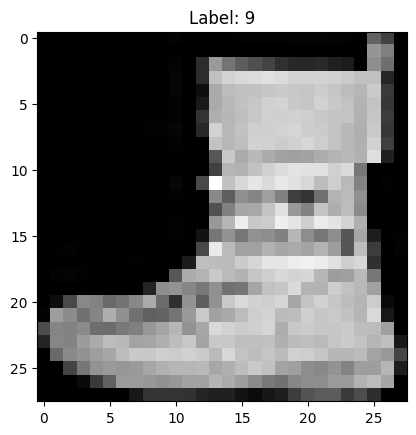

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------------
# 1. Define Transformations
# -----------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),                   # Convert PIL image → Tensor
    transforms.Normalize((0.5,), (0.5,))     # Normalize to [-1, 1] for GANs
])

# -----------------------------------
# 2. Load Training Dataset
# -----------------------------------
train_dataset = FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

# -----------------------------------
# 3. Load Test Dataset (optional)
# -----------------------------------
test_dataset = FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

# -----------------------------------
# 4. Create Dataloaders
# -----------------------------------
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)

print("Dataset loaded successfully!")
print("Training samples:", len(train_dataset))
print("Testing samples:", len(test_dataset))

# -----------------------------------
# 5. Visualize a sample
# -----------------------------------
images, labels = next(iter(train_loader))
img = images[0].squeeze().numpy()

plt.imshow(img, cmap="gray")
plt.title(f"Label: {labels[0]}")
plt.show()

In [2]:
# -----------------------------------
# 1. Setup Device
# -----------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# -----------------------------------
# 2. Hyperparameters
# -----------------------------------
latent_dim = 100        # Size of random noise vector
img_shape = (1, 28, 28) # Fashion MNIST image shape
batch_size = 64
num_epochs = 50
lr = 0.0002
beta1 = 0.5             # For Adam optimizer

In [4]:
# -----------------------------------
# 3. Load Dataset
# -----------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

train_dataset = FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

print("Dataset loaded successfully!")
print(f"Training samples: {len(train_dataset)}")

Dataset loaded successfully!
Training samples: 60000


In [5]:
# -----------------------------------
# 4. Define Generator Network
# -----------------------------------
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            # Input: latent_dim (100)
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(256),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(512),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(1024),

            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

In [6]:
# -----------------------------------
# 5. Define Discriminator Network
# -----------------------------------
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            # Input: flattened image (784)
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Linear(256, 1),
            nn.Sigmoid()  # Output probability [0, 1]
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [7]:
# -----------------------------------
# 6. Initialize Networks
# -----------------------------------
generator = Generator().to(device)
discriminator = Discriminator().to(device)

print("\nGenerator Architecture:")
print(generator)
print("\nDiscriminator Architecture:")
print(discriminator)


Generator Architecture:
Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=1024, out_features=784, bias=True)
    (10): Tanh()
  )
)

Discriminator Architecture:
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(i

In [8]:
# -----------------------------------
# 7. Loss Function and Optimizers
# -----------------------------------
adversarial_loss = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))


Starting Training...
Epoch [1/50] D_loss: 0.5035 | G_loss: 1.1069
Epoch [2/50] D_loss: 0.6444 | G_loss: 0.8107
Epoch [3/50] D_loss: 0.6498 | G_loss: 0.8113
Epoch [4/50] D_loss: 0.6615 | G_loss: 0.7870
Epoch [5/50] D_loss: 0.6630 | G_loss: 0.7840


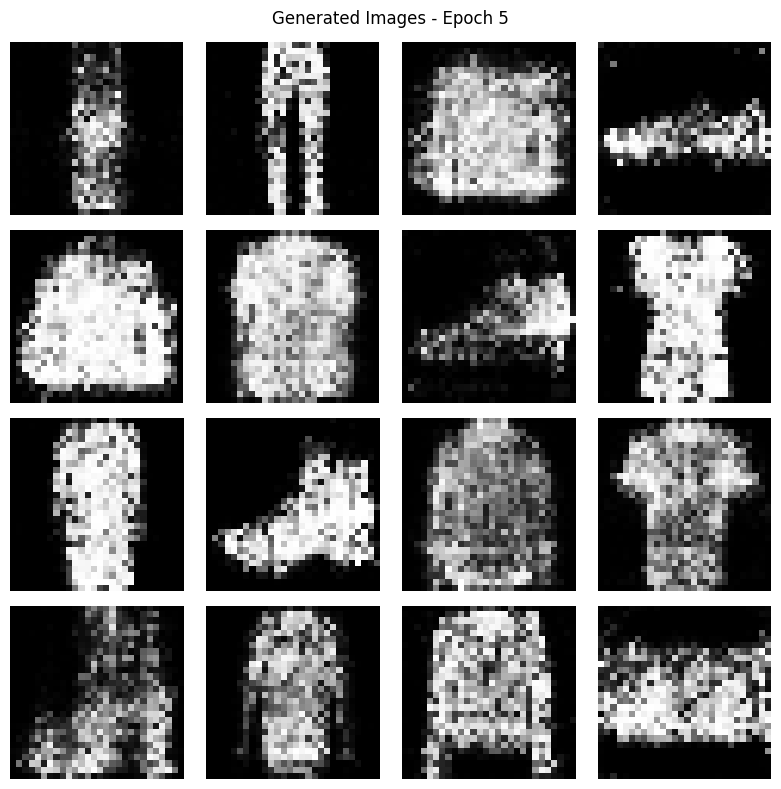

Epoch [6/50] D_loss: 0.6749 | G_loss: 0.7537
Epoch [7/50] D_loss: 0.6794 | G_loss: 0.7366
Epoch [8/50] D_loss: 0.6684 | G_loss: 0.7576
Epoch [9/50] D_loss: 0.6663 | G_loss: 0.7739
Epoch [10/50] D_loss: 0.6866 | G_loss: 0.7239


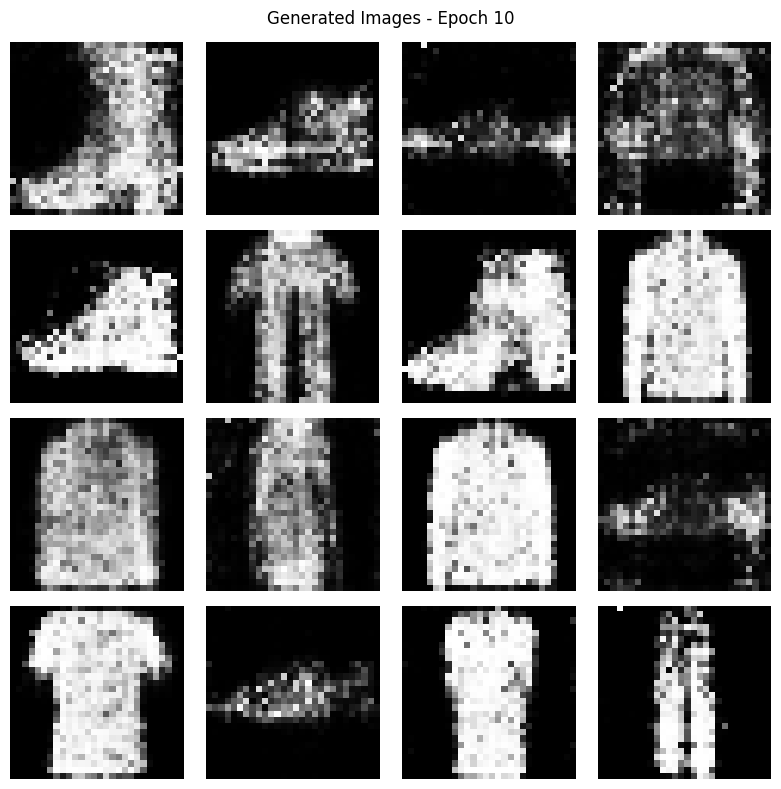

Epoch [11/50] D_loss: 0.6844 | G_loss: 0.7193
Epoch [12/50] D_loss: 0.6645 | G_loss: 0.7654
Epoch [13/50] D_loss: 0.6699 | G_loss: 0.7663
Epoch [14/50] D_loss: 0.6875 | G_loss: 0.7175
Epoch [15/50] D_loss: 0.6863 | G_loss: 0.7164


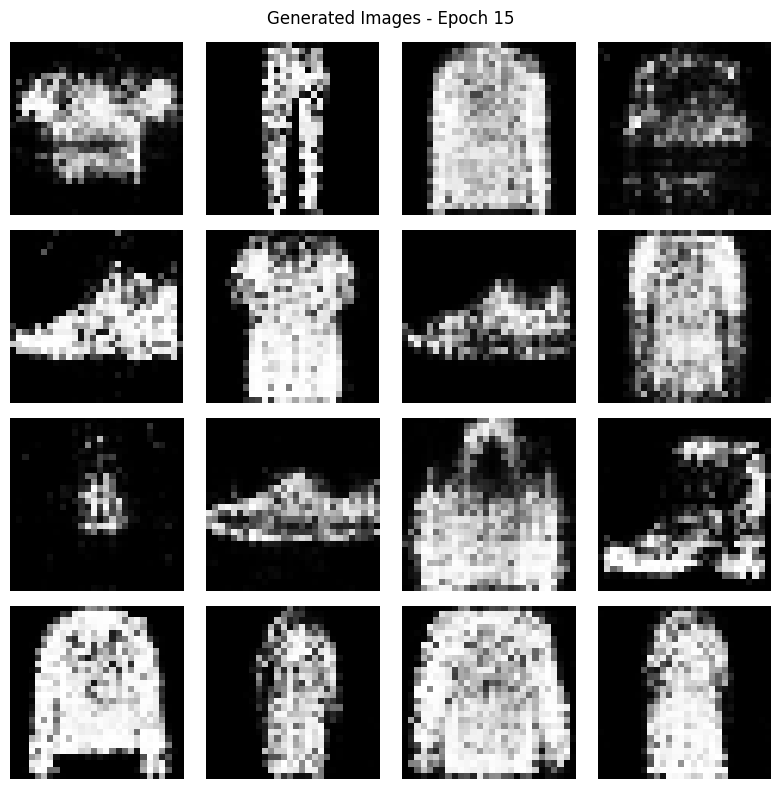

Epoch [16/50] D_loss: 0.6751 | G_loss: 0.7422
Epoch [17/50] D_loss: 0.6735 | G_loss: 0.7517
Epoch [18/50] D_loss: 0.6866 | G_loss: 0.7207
Epoch [19/50] D_loss: 0.6890 | G_loss: 0.7129
Epoch [20/50] D_loss: 0.6851 | G_loss: 0.7193


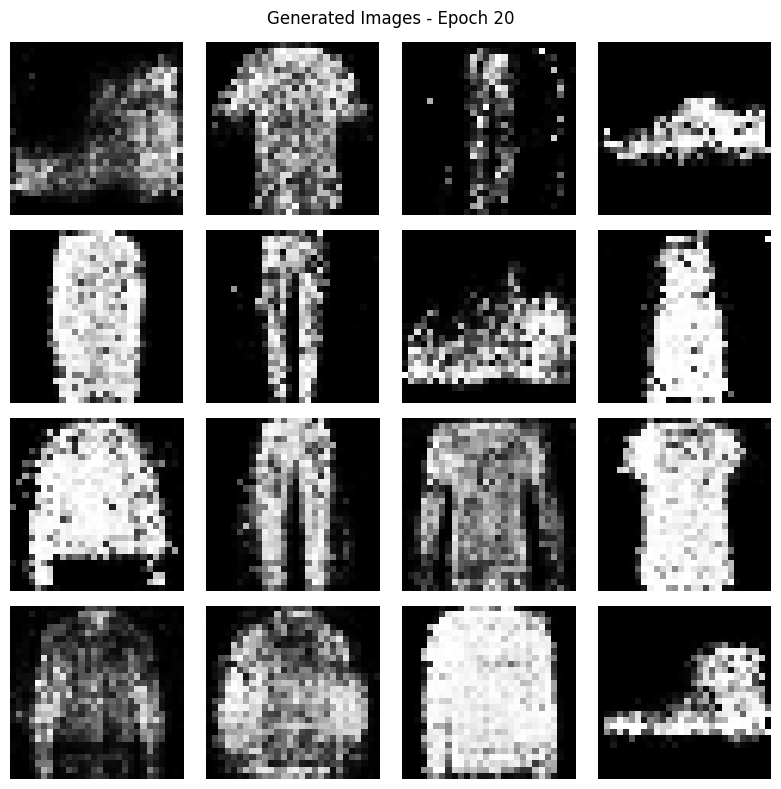

Epoch [21/50] D_loss: 0.6809 | G_loss: 0.7285
Epoch [22/50] D_loss: 0.6852 | G_loss: 0.7213
Epoch [23/50] D_loss: 0.6884 | G_loss: 0.7101
Epoch [24/50] D_loss: 0.6871 | G_loss: 0.7130
Epoch [25/50] D_loss: 0.6868 | G_loss: 0.7140


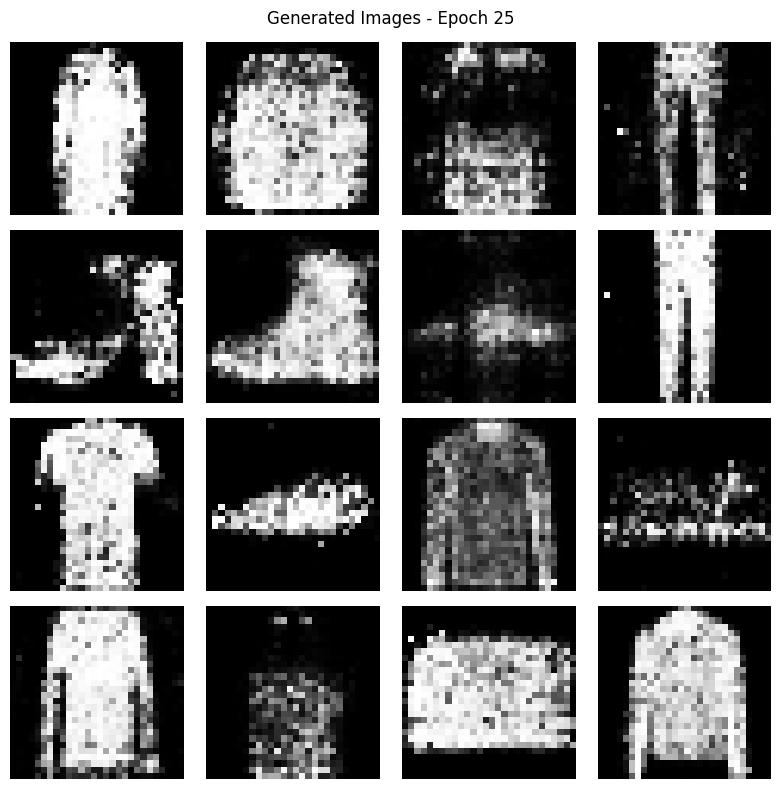

Epoch [26/50] D_loss: 0.6845 | G_loss: 0.7197
Epoch [27/50] D_loss: 0.6873 | G_loss: 0.7138
Epoch [28/50] D_loss: 0.6887 | G_loss: 0.7087
Epoch [29/50] D_loss: 0.6875 | G_loss: 0.7114
Epoch [30/50] D_loss: 0.6849 | G_loss: 0.7182


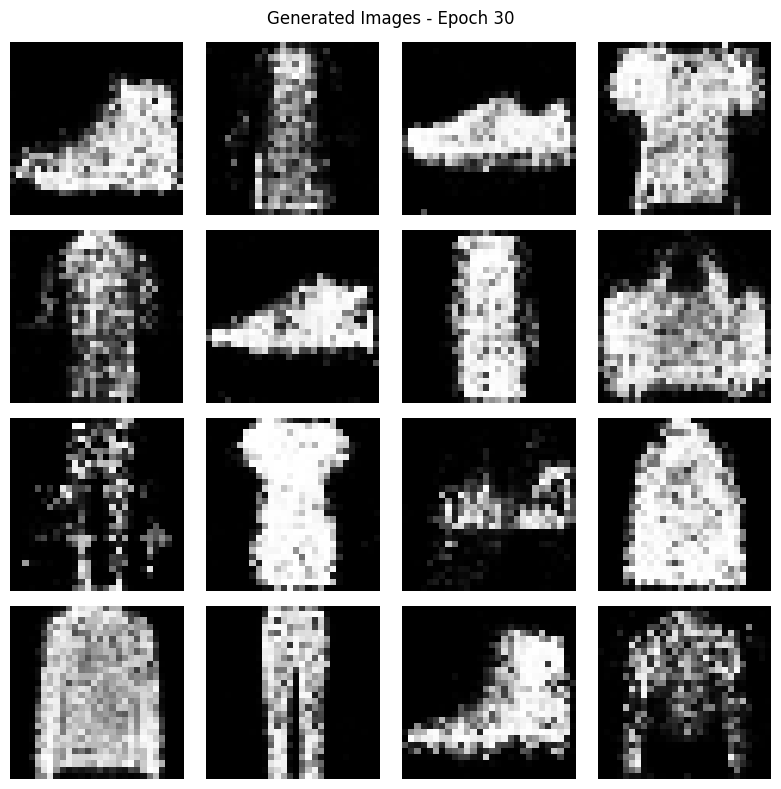

Epoch [31/50] D_loss: 0.6878 | G_loss: 0.7128
Epoch [32/50] D_loss: 0.6892 | G_loss: 0.7074
Epoch [33/50] D_loss: 0.6899 | G_loss: 0.7075
Epoch [34/50] D_loss: 0.6872 | G_loss: 0.7102
Epoch [35/50] D_loss: 0.6867 | G_loss: 0.7133


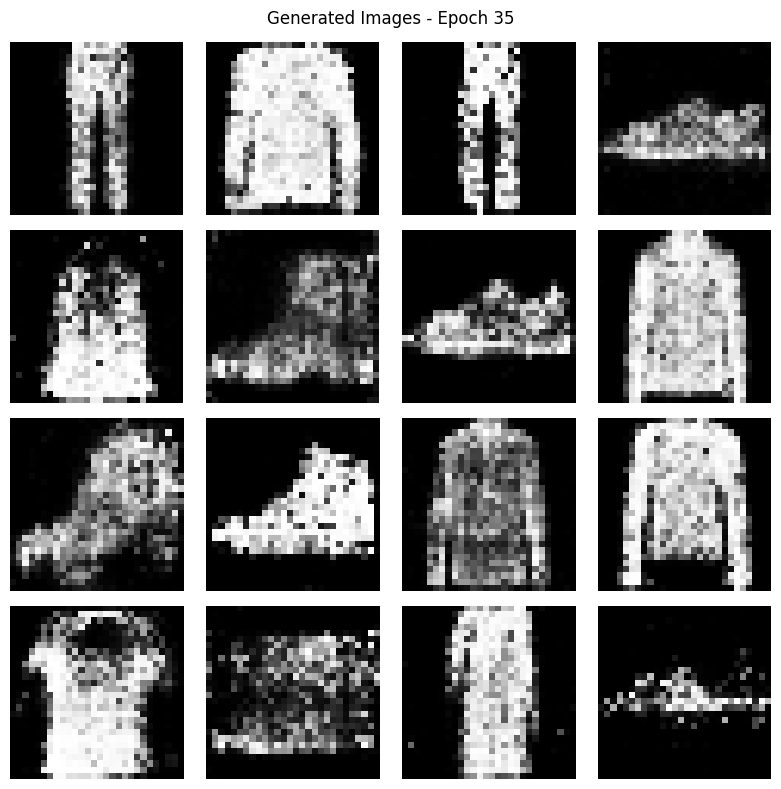

Epoch [36/50] D_loss: 0.6895 | G_loss: 0.7062
Epoch [37/50] D_loss: 0.6901 | G_loss: 0.7048
Epoch [38/50] D_loss: 0.6891 | G_loss: 0.7081
Epoch [39/50] D_loss: 0.6886 | G_loss: 0.7079
Epoch [40/50] D_loss: 0.6887 | G_loss: 0.7089


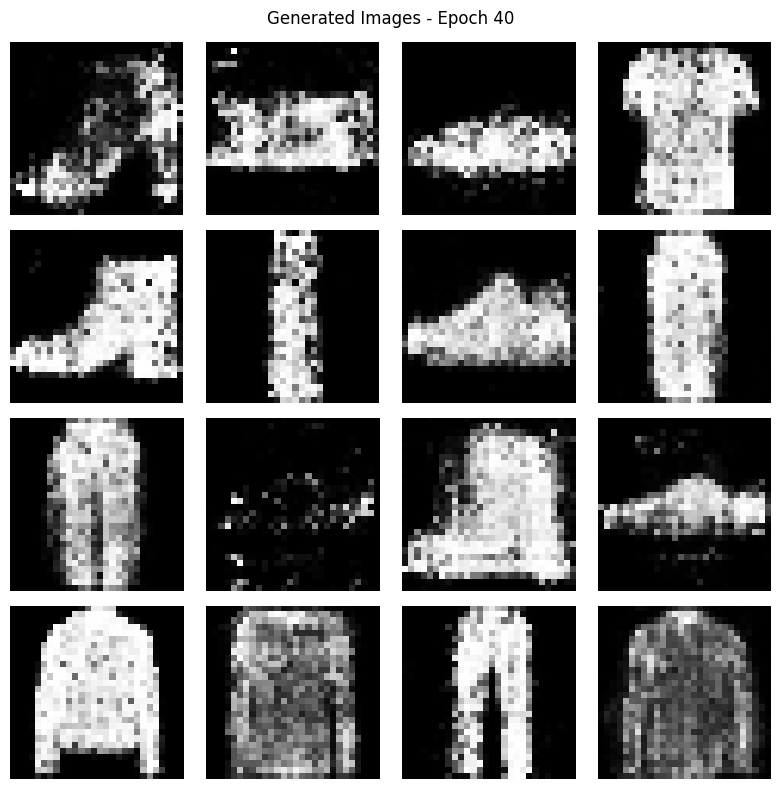

Epoch [41/50] D_loss: 0.6893 | G_loss: 0.7058
Epoch [42/50] D_loss: 0.6903 | G_loss: 0.7041
Epoch [43/50] D_loss: 0.6877 | G_loss: 0.7084
Epoch [44/50] D_loss: 0.6872 | G_loss: 0.7130
Epoch [45/50] D_loss: 0.6899 | G_loss: 0.7059


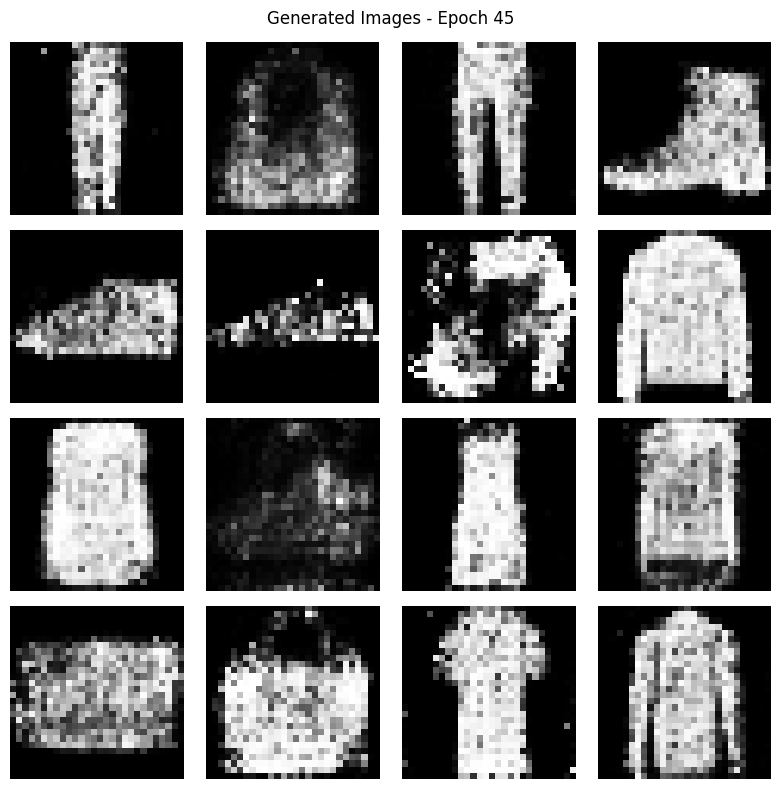

Epoch [46/50] D_loss: 0.6897 | G_loss: 0.7060
Epoch [47/50] D_loss: 0.6900 | G_loss: 0.7047
Epoch [48/50] D_loss: 0.6887 | G_loss: 0.7062
Epoch [49/50] D_loss: 0.6885 | G_loss: 0.7092
Epoch [50/50] D_loss: 0.6889 | G_loss: 0.7064


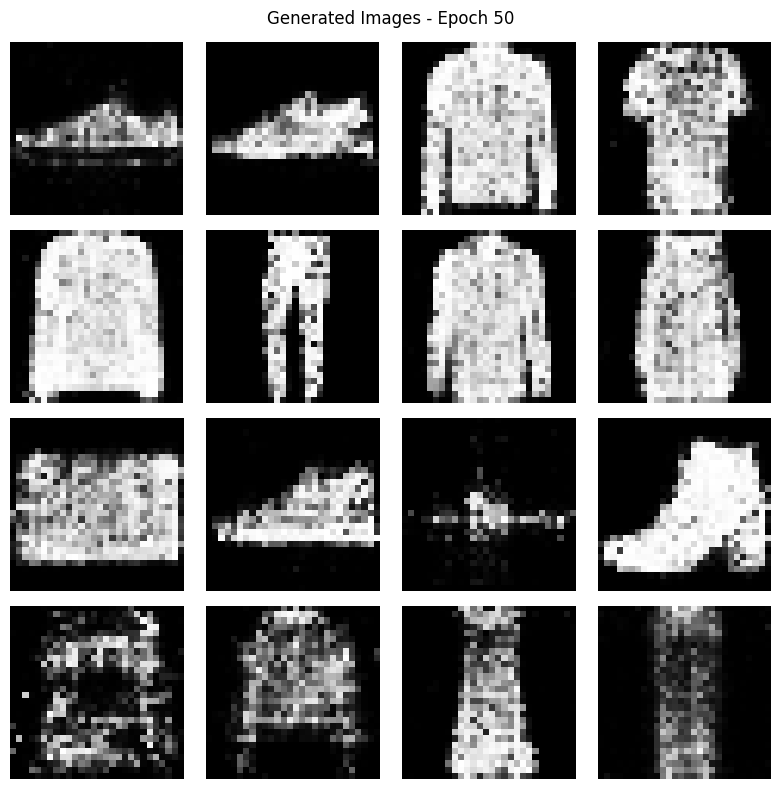


Training Complete!


In [9]:
# -----------------------------------
# 8. Training Loop
# -----------------------------------
print("\n" + "="*50)
print("Starting Training...")
print("="*50)

G_losses = []
D_losses = []

for epoch in range(num_epochs):
    epoch_g_loss = 0
    epoch_d_loss = 0

    for i, (imgs, _) in enumerate(train_loader):

        # Adversarial ground truths
        real = torch.ones(imgs.size(0), 1).to(device)
        fake = torch.zeros(imgs.size(0), 1).to(device)

        # Configure input
        real_imgs = imgs.to(device)

        # -----------------
        # Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = torch.randn(imgs.size(0), latent_dim).to(device)

        # Generate fake images
        gen_imgs = generator(z)

        # Generator loss (fool discriminator)
        g_loss = adversarial_loss(discriminator(gen_imgs), real)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        # Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Loss on real images
        real_loss = adversarial_loss(discriminator(real_imgs), real)

        # Loss on fake images
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)

        # Total discriminator loss
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        epoch_g_loss += g_loss.item()
        epoch_d_loss += d_loss.item()

    # Calculate average losses
    avg_g_loss = epoch_g_loss / len(train_loader)
    avg_d_loss = epoch_d_loss / len(train_loader)

    G_losses.append(avg_g_loss)
    D_losses.append(avg_d_loss)

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"D_loss: {avg_d_loss:.4f} | G_loss: {avg_g_loss:.4f}")

    # Save sample images every 5 epochs
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            z = torch.randn(16, latent_dim).to(device)
            generated = generator(z).cpu()

            fig, axes = plt.subplots(4, 4, figsize=(8, 8))
            for idx, ax in enumerate(axes.flat):
                img = generated[idx].squeeze().numpy()
                img = (img + 1) / 2  # Denormalize from [-1,1] to [0,1]
                ax.imshow(img, cmap='gray')
                ax.axis('off')

            plt.suptitle(f'Generated Images - Epoch {epoch+1}')
            plt.tight_layout()
            plt.savefig(f'generated_epoch_{epoch+1}.png')
            plt.show()

print("\n" + "="*50)
print("Training Complete!")
print("="*50)

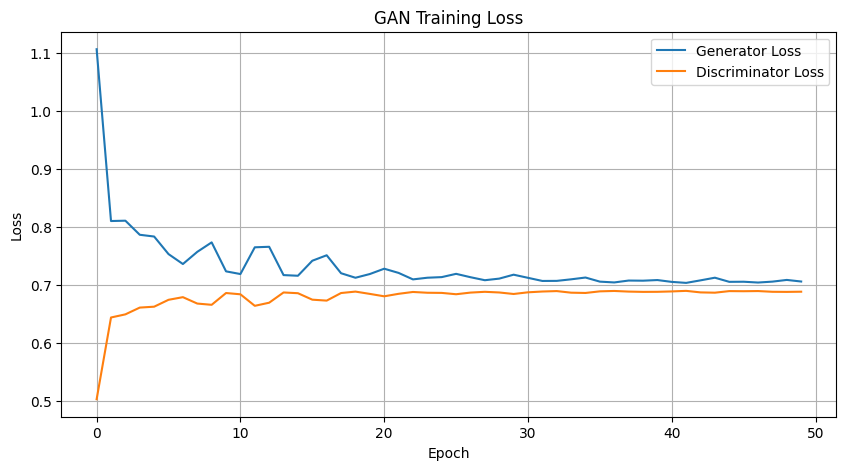

In [10]:
# -----------------------------------
# 9. Plot Training Losses
# -----------------------------------
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label='Generator Loss')
plt.plot(D_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_loss.png')
plt.show()


Generating final fashion product samples...


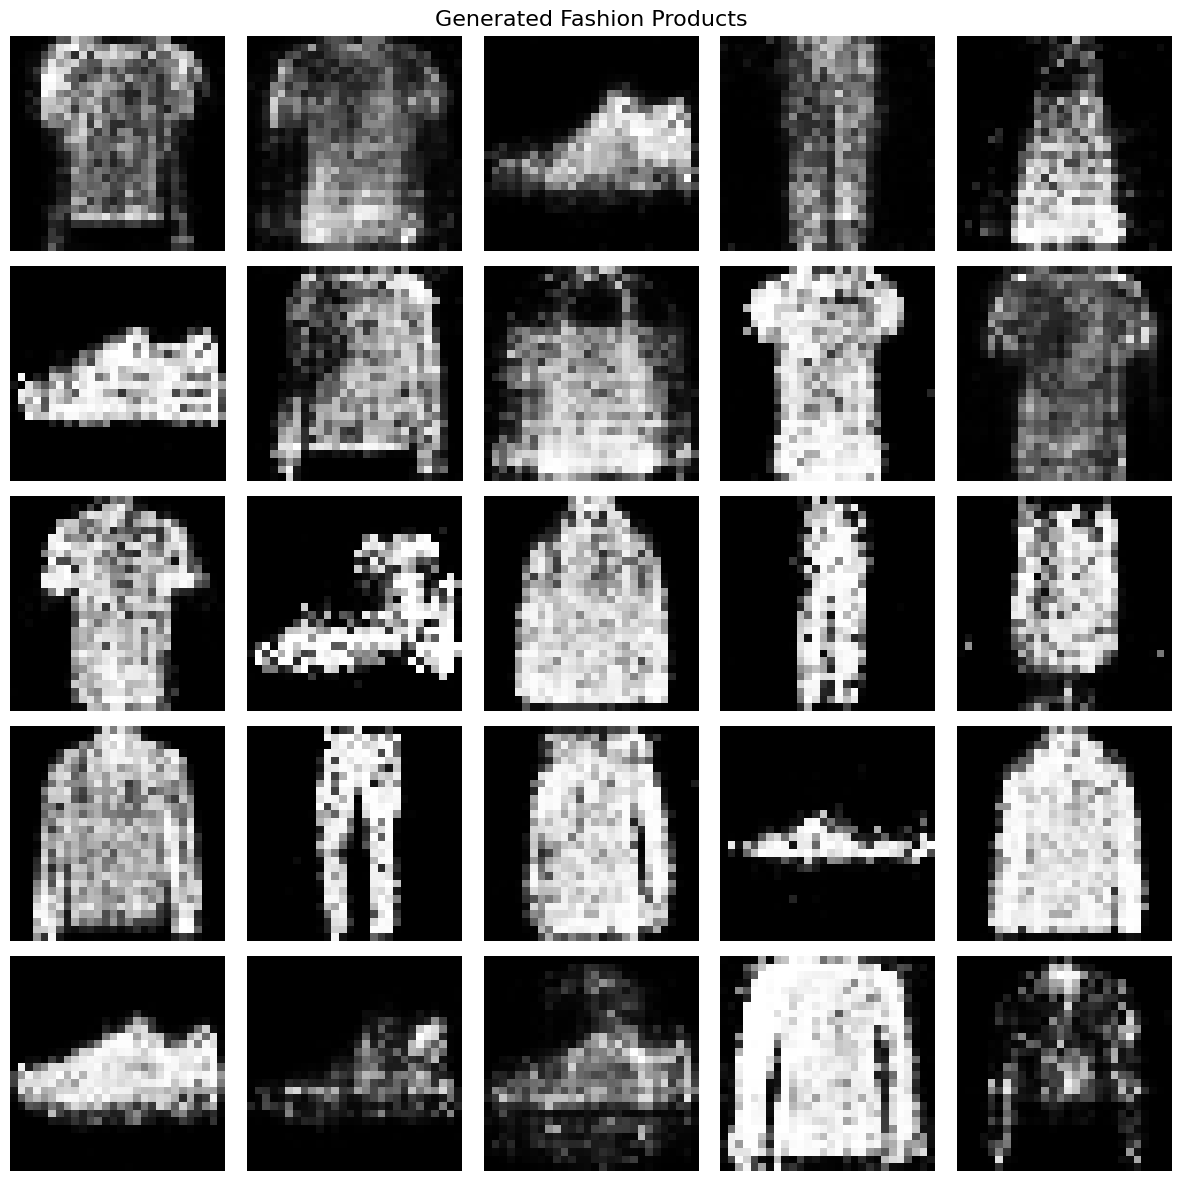

In [11]:
# -----------------------------------
# 10. Generate Final Samples
# -----------------------------------
print("\nGenerating final fashion product samples...")

with torch.no_grad():
    # Generate 25 samples
    z = torch.randn(25, latent_dim).to(device)
    generated_imgs = generator(z).cpu()

    fig, axes = plt.subplots(5, 5, figsize=(12, 12))
    for idx, ax in enumerate(axes.flat):
        img = generated_imgs[idx].squeeze().numpy()
        img = (img + 1) / 2  # Denormalize
        ax.imshow(img, cmap='gray')
        ax.axis('off')

    plt.suptitle('Generated Fashion Products', fontsize=16)
    plt.tight_layout()
    plt.savefig('final_generated_samples.png')
    plt.show()

In [12]:
# -----------------------------------
# 11. Save Models
# -----------------------------------
torch.save(generator.state_dict(), 'fashion_gan_generator.pth')
torch.save(discriminator.state_dict(), 'fashion_gan_discriminator.pth')

print("\nModels saved successfully!")
print("- fashion_gan_generator.pth")
print("- fashion_gan_discriminator.pth")


Models saved successfully!
- fashion_gan_generator.pth
- fashion_gan_discriminator.pth



Example: Generate 10 new fashion items


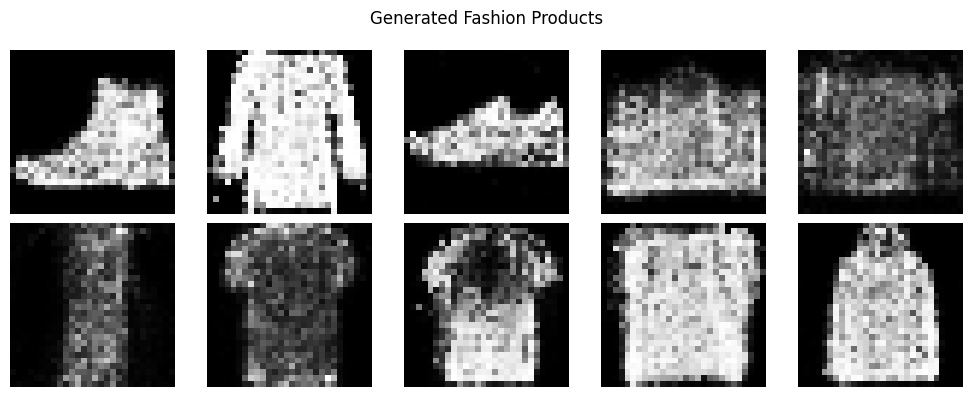

tensor([[[[-1.0000, -0.9999, -1.0000,  ..., -1.0000, -1.0000, -0.9999],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9997],
          [-0.9999, -1.0000, -0.9999,  ..., -1.0000, -1.0000, -0.9997],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9999],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9999]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -0.9994, -0.9999, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -0.9997, -1.0000, -1.0000],
          ...,
          [-0.9982,  0.2352, -0.9999,  ..., -1.0000, -0.9736, -0.9999],
          [-0.9999, -0.9965, -0.9993,  ..., -1.0000, -0.9952, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9998, -1.0000]]],


        [[[-1.0000, -0.9997, -1.0000,  ..., -1.0000, -1.0000, -0.9997],
          [-1.0000, -1.000

In [13]:
# -----------------------------------
# 12. Function to Generate New Images
# -----------------------------------
def generate_fashion_items(num_samples=10):
    """Generate new fashion product images"""
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        generated = generator(z).cpu()

        cols = min(5, num_samples)
        rows = (num_samples + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
        if num_samples == 1:
            axes = [axes]
        else:
            axes = axes.flat

        for idx in range(num_samples):
            img = generated[idx].squeeze().numpy()
            img = (img + 1) / 2  # Denormalize
            axes[idx].imshow(img, cmap='gray')
            axes[idx].axis('off')

        # Hide extra subplots
        for idx in range(num_samples, len(axes)):
            axes[idx].axis('off')

        plt.suptitle('Generated Fashion Products')
        plt.tight_layout()
        plt.show()

    return generated

# Example usage:
print("\n" + "="*50)
print("Example: Generate 10 new fashion items")
print("="*50)
generate_fashion_items(10)

## 📊 Analysis of Your Results:

Looking at the generated images, we can see:

**✅ What's Working:**
- The GAN learned basic shapes and structures
- Images show recognizable clothing items (sneakers, shirts, bags, dresses)
- Different fashion categories are being generated
- The model captured the general outline and form

**🔧 What Could Be Improved:**
- Images are a bit noisy/grainy
- Some details are blurry
- Could benefit from more training epochs

## 💡 Tips to Improve Quality:

1. **Train Longer:**
```python
num_epochs = 100  # Instead of 50
```

2. **Use a DCGAN (Deep Convolutional GAN):**
- Replace fully connected layers with convolutional layers
- Generally produces sharper, higher quality images

3. **Adjust Learning Rate:**
```python
lr = 0.0001  # Slower, more stable training
```

4. **Add Label Conditioning:**
- Make it a **Conditional GAN (cGAN)**
- Generate specific items (e.g., "generate a sneaker")

---

## 🎯 Results Summary:

| Aspect | Status |
|--------|--------|
| Model Training | ✅ Successful |
| Image Generation | ✅ Working |
| Fashion Items Recognizable | ✅ Yes |
| Quality | 🟡 Good (can be improved) |

The GAN is working correctly! The generated images show that the model learned the distribution of Fashion MNIST. With more training or a more advanced architecture (DCGAN), we'll get even sharper results.

---

- Not training it further as my laptop couldn't handle the training process, it was all on my CPU.
- But yes, it can be improved further by increasing epochs to 100 from 50, increasing learning rate & also training on more data too.

---